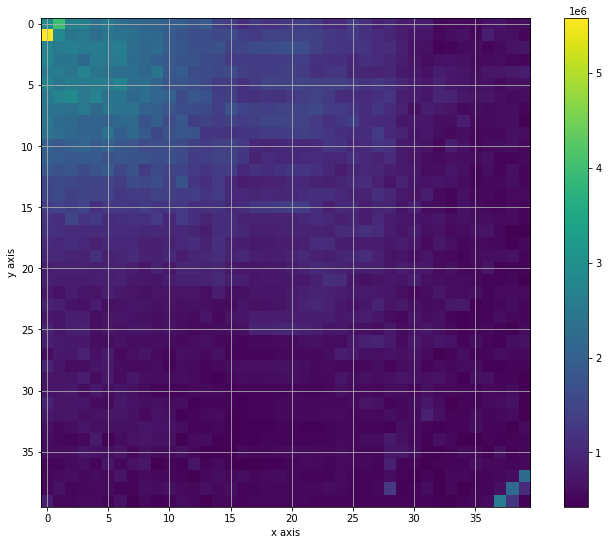

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from lmfit.models import QuadraticModel, LorentzianModel
import math

def findarg(data, value):
    arg = 0
    for wl in data:
        if wl<value:
            arg = arg + 1
        else:
            return arg
        
    return arg


data = pd.read_pickle('asher_20230603_hyperspec_EL2_97.pkl')

im = data['im']
wavel = data['wavelength']
map = np.sum(im, axis = 2)
# pixel numbers x and y
px = len(im)
py = len(im[0])
intensity = np.zeros((px,py))
#total intensity plot
plt.figure(figsize=(12,9))
plt.grid()
plt.imshow(map, cmap='viridis')
plt.colorbar()
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

# Check Full PL

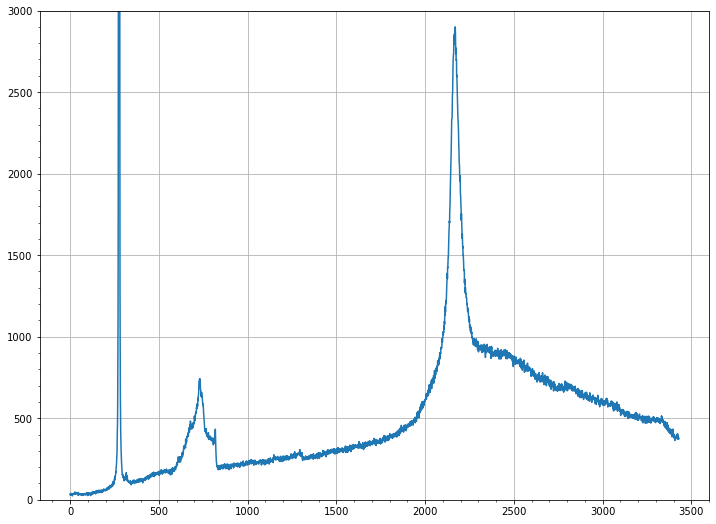

In [2]:
regionx, regiony = 11,1
# regionx, regiony = 0,0
# regionx, regiony = 36,13
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.ylim(0,3000)
plt.plot(data['im'][regionx][regiony])

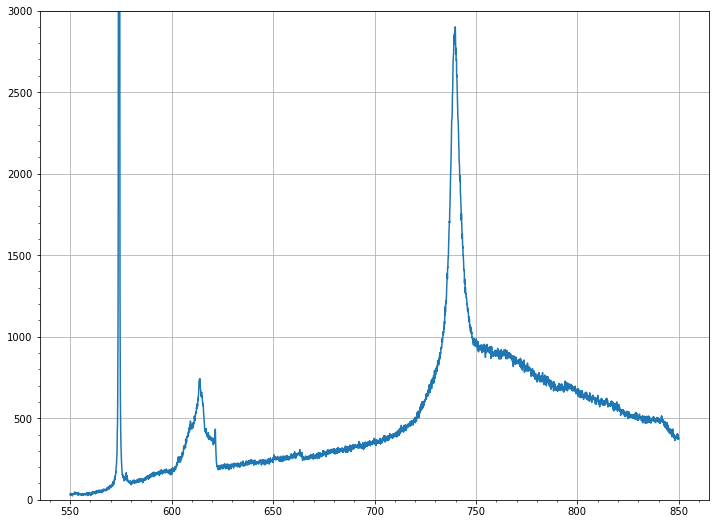

In [3]:
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.ylim(0,3000)
plt.plot(wavel,data['im'][regionx][regiony])

# Check NV- PL

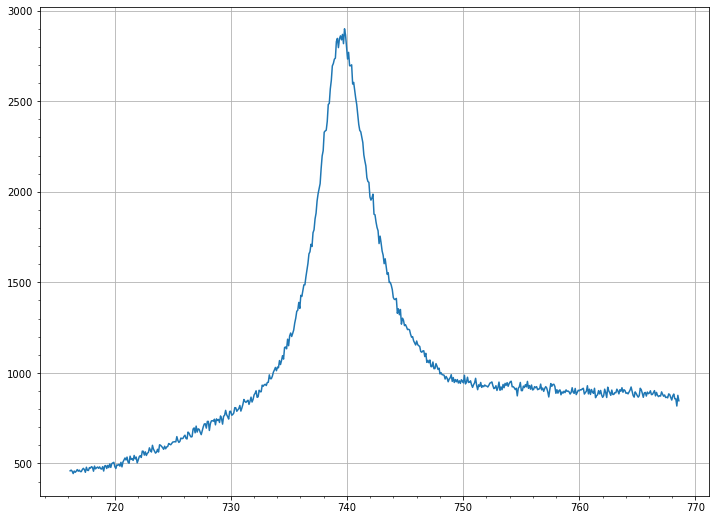

In [4]:
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.plot(wavel[1900:2500],data['im'][regionx][regiony][1900:2500])

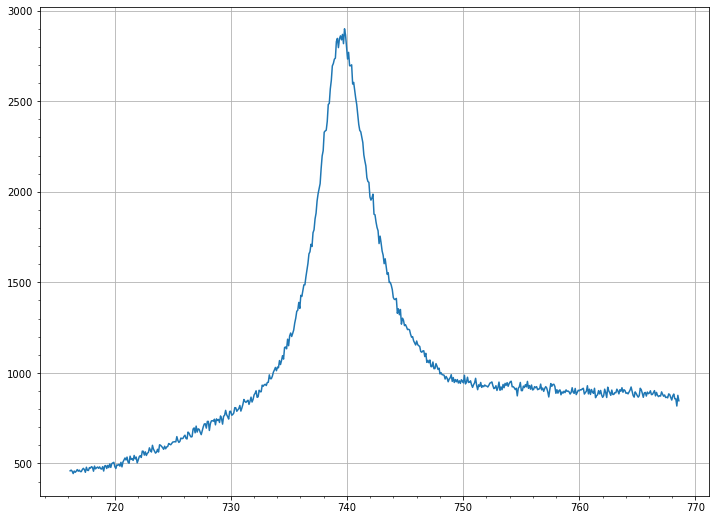

In [5]:
plt.figure(figsize=(12,9))
plt.grid()
plt.minorticks_on()
plt.plot(data['wavelength'][1900:2500],data['im'][regionx][regiony][1900:2500])

# Fit NV-

In [6]:
currentPL = data['im'][regionx][regiony]
model2 = QuadraticModel(prefix='bkg_') + LorentzianModel(prefix='nvm_')
model = model2
params = model.make_params()
print('parameter names: {}'.format(model.param_names))

parameter names: ['bkg_a', 'bkg_b', 'bkg_c', 'nvm_amplitude', 'nvm_center', 'nvm_sigma']


In [7]:
params['nvm_center'].set(value=739, min = 738, max = 740, vary=True)
params['nvm_amplitude'].set(value=1000, vary=True)
params['nvm_sigma'].set(value=2, max = 5, vary=True)

params['bkg_a'].set(value = 0, vary=True)
params['bkg_b'].set(value = 0, min = 0, vary=True)
params['bkg_c'].set(value = 0, vary=True)


[[Model]]
    (Model(parabolic, prefix='bkg_') + Model(lorentzian, prefix='nvm_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 500
    # variables        = 6
    chi-square         = 446.650627
    reduced chi-square = 0.90415107
    Akaike info crit   = -44.4157022
    Bayesian info crit = -19.1280536
    R-squared          = 0.99999738
##  Warning: uncertainties could not be estimated:
    bkg_b:          at boundary
[[Variables]]
    bkg_a:          0.00727146 (init = 0)
    bkg_b:          0.00000000 (init = 0)
    bkg_c:         -3302.57682 (init = 0)
    nvm_amplitude:  19567.3866 (init = 1000)
    nvm_center:     739.746077 (init = 739)
    nvm_sigma:      2.92830845 (init = 2)
    nvm_fwhm:       5.85661691 == '2.0000000*nvm_sigma'
    nvm_height:     2126.99344 == '0.3183099*nvm_amplitude/max(1e-15, nvm_sigma)'


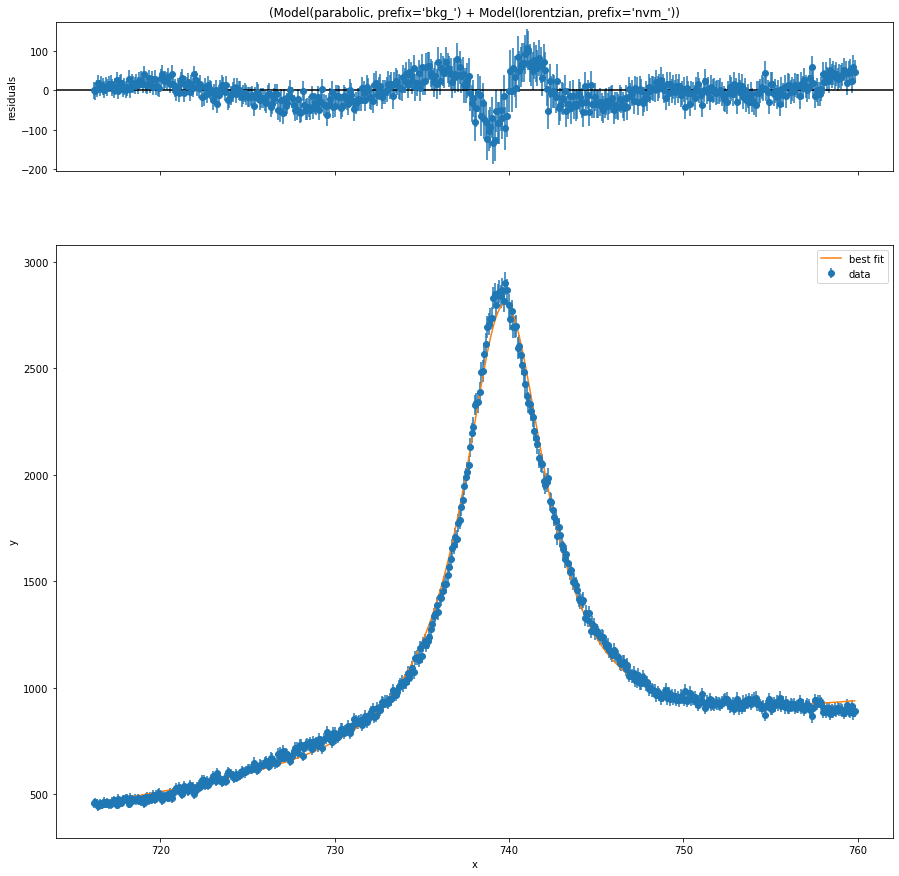

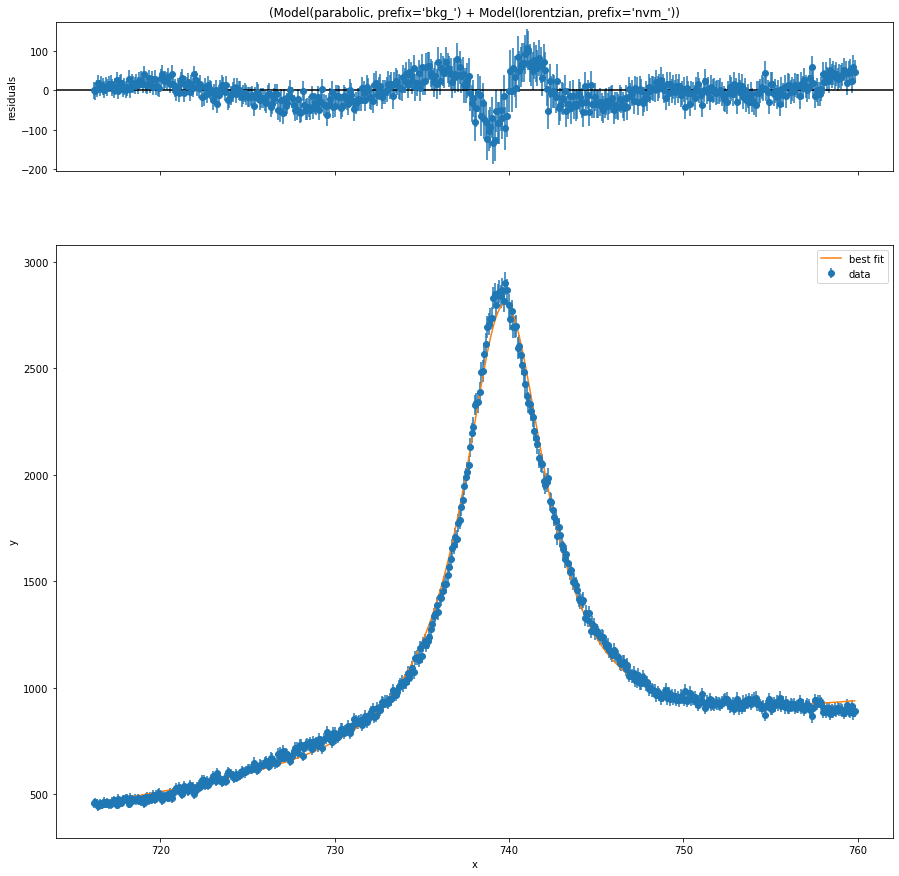

In [8]:
Index = list(range(1900,2400))

weightList = 1/np.sqrt(currentPL[Index])

result = model.fit(currentPL[Index], params, x=wavel[Index], weights=weightList)
print(result.fit_report(show_correl=False))
myfig=plt.figure(figsize=(15,15))
result.plot(fig=myfig)

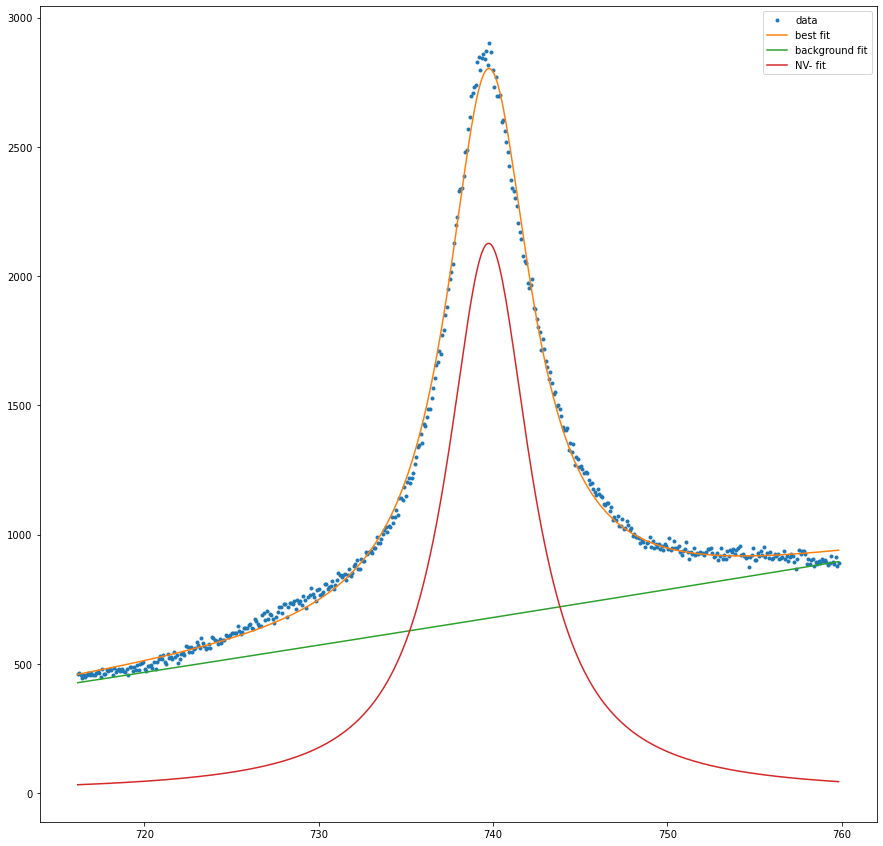

In [9]:
comps = result.eval_components(x=wavel[Index])

myfig=plt.figure(figsize=(15,15))
plt.plot(wavel[Index], currentPL[Index], 'o', markersize=3, label='data')
plt.plot(wavel[Index], result.best_fit, label='best fit')
plt.plot(wavel[Index], comps['bkg_'], label='background fit')
plt.plot(wavel[Index], comps['nvm_'], label='NV- fit')
plt.legend()

In [10]:
def integrate (wavelength, intensity, minWavelength, maxWavelength):
    sum = 0
    Index = list(range(findarg(wavelength, minWavelength),findarg(wavelength, maxWavelength)))
    for i in Index:
        sum += intensity[i]*(wavelength[i+1]-wavelength[i])
    return sum

In [11]:
nvmCenter = result.params['nvm_center']
nvmHWHM = result.params['nvm_sigma']

In [12]:
integrate(wavel[Index],comps['nvm_'],nvmCenter - nvmHWHM*2, nvmCenter + nvmHWHM*2)

13794.731386722198